## Loading and cleaning the data


In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns   
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_excel(r'C:/Users/joeri/OneDrive - Vrije Universiteit Amsterdam/BA honours project/BA honours.xlsx')
df = df.rename(columns={'Seizoen': 'Season', 'Datum' : 'Date', 'Thuisclub' : 'Home team', 'Uitclub' : 'Away team', 'Thuisscore' : 'Home score', 'Uitscore' : 'Away score'})

df = df.replace({"\xa0Feijenoord" : "Feyenoord", "\xa0ADO" : "ADO Den Haag", "\xa0Alkmaar" : "AZ", "\xa0AZ `67" : "AZ", "\xa0BVV" : "FC Den Bosch", "\xa0Cambuur Leeuwaard" : "SC Cambuur",
                "\xa0Dordrecht `90" : "FC Dordrecht", "\xa0DS `79" : "FC Dordrecht", "\xa0DWS/A" : "DWS", "\xa0BVV Den Bosch" : "FC Den Bosch", "\xa0FC Den Haag" : "ADO Den Haag", "\xa0FC Twente `65" : "FC Twente",
                "\xa0FC VVV" : "VVV-Venlo", "\xa0FC Zwolle" : "PEC Zwolle", "\xa0Fortuna `54" : "Fortuna Sittard", "\xa0FSC" : "Fortuna Sittard", "\xa0Go Ahead" : "Go Ahead Eagles", "\xa0GVAV" : "FC Groningen",
                "\xa0Heracles" : "Heracles Almelo", "\xa0NAC" : "NAC Breda", "\xa0Rapid JC" : "Roda JC", "\xa0RKC" : "RKC Waalwijk", "\xa0SC Enschede" : "FC Twente", "\xa0Sittardia" : "Fortuna Sittard", "\xa0Sparta" : "Sparta Rotterdam", "\xa0SVV/Dordrecht `90" : "FC Dordrecht",
                "\xa0VVV" : "VVV-Venlo", "\xa0Xerxes/DHC `66" : "Xerxes"})

dataframes_dict = {}

for i in range(1956, 2023):
    year_range = str(i) + '-' + str(i + 1)
    dataframes_dict[i] = df[df['Season'] == year_range].reset_index(drop=True)

dataframes_dict[2022].head()

,Season,Date,Home team,Away team,Home score,Away score
0,2022-2023,2022-08-05,SC Heerenveen,Sparta Rotterdam,0,0
1,2022-2023,2022-08-06,Fortuna Sittard,Ajax,2,3
2,2022-2023,2022-08-06,PSV,FC Emmen,4,1
3,2022-2023,2022-08-06,RKC Waalwijk,FC Utrecht,2,2
4,2022-2023,2022-08-06,SC Cambuur,Excelsior,0,2


### Adding column 'Matchday' to the dataframe

In [2]:
for i in range(1956, 2023):
    dataframes_dict[i]['Matchday'] = 0
    matchesPlayed = {}
    for j in range(len(dataframes_dict[i])):
        home_team = dataframes_dict[i].iloc[j]['Home team']
        away_team = dataframes_dict[i].iloc[j]['Away team']

        matchesPlayed[home_team] = matchesPlayed.get(home_team, 0) + 1
        matchesPlayed[away_team] = matchesPlayed.get(away_team, 0) + 1

        dataframes_dict[i].iloc[j, dataframes_dict[i].columns.get_loc('Matchday')] = matchesPlayed[home_team]

### Creating a function that returns the standings for any season and any matchday

In [3]:
def standings(Season: pd.DataFrame, matchday: int) -> pd.DataFrame:
    Season['Home team'] = Season['Home team'].str.strip()
    Season['Away team'] = Season['Away team'].str.strip()
    
    if Season['Matchday'].iloc[-1] < matchday:
        matchday = Season['Matchday'].iloc[-1] 
    
    Matchday_df = Season[Season['Matchday'] <= matchday]
        
    team_goals_scored = {}
    team_goals_conceded = {}
    team_won = {}
    team_draw = {}
    team_loss = {}
    for index, row in Matchday_df.iterrows():
        home_team = row['Home team']
        away_team = row['Away team']
        home_score = row['Home score']
        away_score = row['Away score']

        if home_team not in team_goals_scored:
            team_goals_scored[home_team] = 0
            team_goals_conceded[home_team] = 0
            team_won[home_team] = 0
            team_draw[home_team] = 0
            team_loss[home_team] = 0
            
        if away_team not in team_goals_scored:
            team_goals_scored[away_team] = 0
            team_goals_conceded[away_team] = 0
            team_won[away_team] = 0
            team_draw[away_team] = 0
            team_loss[away_team] = 0
            
        team_goals_scored[home_team] += home_score
        team_goals_scored[away_team] += away_score
        team_goals_conceded[home_team] += away_score
        team_goals_conceded[away_team] += home_score
        
        if home_score > away_score:
            team_won[home_team] += 1
            team_loss[away_team] += 1
        elif home_score == away_score:
            team_draw[home_team] += 1
            team_draw[away_team] += 1
        else:
            team_won[away_team] += 1
            team_loss[home_team] += 1
    
    standings_df = pd.DataFrame({'Team': list(team_won.keys()), 'Matchday' : matchday , 'W' : list(team_won.values()), 'D' : list(team_draw.values()), 'L' : list(team_loss.values())})

    standings_df['GF'] = list(team_goals_scored.values())
    
    standings_df['GA'] = list(team_goals_conceded.values())
    
    standings_df['+/-'] = standings_df['GF'] - standings_df['GA']
    
    if int(Season['Season'].iloc[0].strip()[0:4]) < 1995:
        standings_df['Pts'] = 2*standings_df['W'] + standings_df['D']
    else:
        standings_df['Pts'] = 3*standings_df['W'] + standings_df['D']
        
    standings_df = standings_df.sort_values(by='Pts', ascending=False).reset_index(drop = True)
    
    standings_df.index += 1  
    
    return standings_df


In [4]:
print(standings(dataframes_dict[1957], 6))


                Team  Matchday  W  D  L  GF  GA  +/-  Pts
1            Roda JC         6  5  1  0  15   7    8   11
2       ADO Den Haag         6  4  1  1  18  11    7    9
3               Ajax         6  4  0  2  14   5    9    8
4          FC Twente         6  4  0  2  18  12    6    8
5   Sparta Rotterdam         6  4  0  2  19  11    8    8
6                DOS         6  3  2  1  11  11    0    8
7          NAC Breda         6  4  0  2  12   8    4    8
8       FC Den Bosch         6  2  2  2  14  13    1    6
9                MVV         6  3  0  3  12  12    0    6
10         Feyenoord         6  2  1  3  17  20   -3    5
11   Fortuna Sittard         6  2  1  3   9  11   -2    5
12      FC Groningen         6  2  1  3  11  14   -3    5
13               PSV         6  2  1  3  11  15   -4    5
14     BVC Amsterdam         6  1  2  3   9  15   -6    4
15         VVV-Venlo         6  2  0  4   7   8   -1    4
16              NOAD         6  1  1  4   9  18   -9    3
17         Bla

### Calculating the home advantage that is used later

In [5]:
homeWins_draws_awayWins = [0,0,0]
number_of_eredivisie_games = 0
for year in range(1956, 2023):
    season_data = dataframes_dict[year]
    for index, row in season_data.iterrows(): 
        number_of_eredivisie_games += 1
        if row["Home score"] > row["Away score"]:
            homeWins_draws_awayWins[0] += 1
        elif row["Home score"] == row["Away score"]:
            homeWins_draws_awayWins[1] += 1
        else:
            homeWins_draws_awayWins[2] += 1
percentages = [0,0,0]
percentages[0] = round(homeWins_draws_awayWins[0] / number_of_eredivisie_games * 100, 2)
percentages[1] = round(homeWins_draws_awayWins[1] / number_of_eredivisie_games * 100, 2)
percentages[2] = round(homeWins_draws_awayWins[2] / number_of_eredivisie_games * 100, 2)

homeAdvantage = [0] * 5
homeAdvantage[0] = ((percentages[0] / (100 / 3)) - 1) / 2 + 1
homeAdvantage[1] = (percentages[1] / (100 / 3) - 1) / 2 + 1
homeAdvantage[2] = (percentages[2] / (100 / 3) - 1) / 2 + 1
homeAdvantage[3] = ((homeAdvantage[0] - 1) * homeAdvantage[1]) + 1
homeAdvantage[4] = 1 - ((1 - homeAdvantage[2]) * homeAdvantage[1]) 
homeAdvantage



[1.2164, 0.8769499999999999, 0.90665, 1.18977198, 0.9181367174999999]

# Predicting the final score based of different ranking methods


In this section, we will write functions that represent different ranking methods that are used globally. These ranking methods will be compared later on in this study.  

### The standard 0,1,3 point system

In [6]:
def currently_used_ranking(Season: pd.DataFrame, matchday: int):    
    prediction = standings(Season, matchday)[["Team", "Pts"]]
    prediction.set_index("Team", inplace = True)
    
    prediction["Pts"] =  (prediction["Pts"] * Season["Matchday"].iloc[-1] / matchday).astype(int) 
    prediction = prediction.rename(columns = {'Pts': 'Pts_predicted'})
    
    return prediction


In [7]:
currently_used_ranking(dataframes_dict[2022], 17)

,Pts_predicted
Team,
AZ,78
Feyenoord,76
PSV,70
FC Twente,68
Ajax,66
Sparta Rotterdam,62
SC Heerenveen,54
FC Utrecht,52
NEC,44


### A simple (0, 0.5, 1) Markov chain

In [8]:
def Simple_Markov_Simulation(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]

        
        
        match_seen_before = int(Transition_matrix[home_team, away_team] + Transition_matrix[away_team, home_team] == 1)

        if home_score > away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + 1) / (1 + match_seen_before)
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + 1/2) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + 1/2) / (1 + match_seen_before)
        else: 
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + 1) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] / (1 + match_seen_before)

    P = normalize(Transition_matrix, axis=1, norm='l1')
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
    
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [9]:
def Simple_Markov_Simulation_b(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]

        
        
        match_seen_before = int(Transition_matrix[home_team, away_team] + Transition_matrix[away_team, home_team] == 1)

        if home_score > away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + (1/homeAdvantage[0])) / (1 + match_seen_before)
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + (1/2)/homeAdvantage[4]) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + (1/2)/homeAdvantage[3]) / (1 + match_seen_before)
        else: 
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + (1/homeAdvantage[2])) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] / (1 + match_seen_before)

    P = normalize(Transition_matrix, axis=1, norm='l1')
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
    
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [10]:
def Simple_Markov_Simulation_c(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    iteration = 0
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]

        match_seen_before = int(Transition_matrix[home_team, away_team] + Transition_matrix[away_team, home_team] == 1)

        if home_score > away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + 1) / (1 + match_seen_before)
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + 1/2) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + 1/2) / (1 + match_seen_before)
        else: 
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + 1) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] / (1 + match_seen_before)
        
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Transition_matrix:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i] / 2)
                    i += 1       
            
    P = normalize(Transition_matrix, axis=1, norm='l1')
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
    
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [11]:
def Simple_Markov_Simulation_d(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    iteration = 0
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]

        match_seen_before = int(Transition_matrix[home_team, away_team] + Transition_matrix[away_team, home_team] == 1)

        if home_score > away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + (1/homeAdvantage[0])) / (1 + match_seen_before)
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + (1/2)/homeAdvantage[4]) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = (Transition_matrix[away_team, home_team] + (1/2)/homeAdvantage[3]) / (1 + match_seen_before)
        else: 
            Transition_matrix[home_team, away_team] = (Transition_matrix[home_team, away_team] + (1/homeAdvantage[2])) / (1 + match_seen_before)
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] / (1 + match_seen_before)
        
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Transition_matrix:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i] / 2)
                    i += 1       
            
    P = normalize(Transition_matrix, axis=1, norm='l1')
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
    
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [12]:
Simple_Markov_Simulation_d(dataframes_dict[2022], 17)

,Pts_predicted
AZ,84
Feyenoord,81
PSV,77
FC Twente,68
Ajax,67
SC Heerenveen,53
NEC,50
Sparta Rotterdam,48
FC Utrecht,47
Go Ahead Eagles,37


### (1, α) Markov Method

In [13]:
def alpha_markov(Season: pd.DataFrame, matchday: int, alpha: int, home_advantage: list):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    iteration = 0
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]
    
        if home_score > away_score:
            streak[home_team] += 1
            streak[away_team] = 0
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + 1 
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + alpha 
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + (1 + alpha) * 1/2
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + (1 + alpha) * 1/2
        else: 
            streak[home_team] = 0
            streak[away_team] += 1
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + alpha 
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + 1 
            
#         if ((iteration) % len(allTeams)) == 0:
#             streak = [x / (len(allTeams) - 9) for x in streak]
#             Transition_matrix = Transition_matrix + streak

    P = normalize(Transition_matrix, axis=1, norm='l1') 
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
        
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    
    return df.sort_values(by="Pts_predicted", ascending=False)

In [14]:
def alpha_markov_b(Season: pd.DataFrame, matchday: int, alpha: int, home_advantage: list):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    iteration = 0
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]
    
        if home_score > away_score:
            streak[home_team] += 1
            streak[away_team] = 0
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + 1 / homeAdvantage[2]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + alpha / homeAdvantage[0] 
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + ((1 + alpha) * 1/2) / homeAdvantage[4]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + ((1 + alpha) * 1/2) / homeAdvantage[3]
        else: 
            streak[home_team] = 0
            streak[away_team] += 1
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + alpha / homeAdvantage[2]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + 1 / homeAdvantage[0]
        
#         if ((iteration) % len(allTeams)) == 0:
#             streak = [x / (len(allTeams) - 9) for x in streak]
#             Transition_matrix = Transition_matrix + streak

    P = normalize(Transition_matrix, axis=1, norm='l1') 
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
        
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    
    return df.sort_values(by="Pts_predicted", ascending=False)

In [15]:
def alpha_markov_c(Season: pd.DataFrame, matchday: int, alpha: int, home_advantage: list):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    iteration = 0
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]
                
        if home_score > away_score:
            streak[home_team] += 1
            streak[away_team] = 0
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + 1 
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + alpha 
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + (1 + alpha) * 1/2
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + (1 + alpha) * 1/2
        else: 
            streak[home_team] = 0
            streak[away_team] += 1
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + alpha 
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + 1 
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Transition_matrix:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i])
                    i += 1
        
    P = normalize(Transition_matrix, axis=1, norm='l1') 
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
        
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [16]:
def alpha_markov_d(Season: pd.DataFrame, matchday: int, alpha: int, home_advantage: list):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    streak = [0] * len(allTeams)    
    Transition_matrix = np.zeros((len(allTeams), len(allTeams)))
    
    iteration = 0
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        home_score = row["Home score"]
        away_score = row["Away score"]
                
        if home_score > away_score:
            streak[home_team] += 1
            streak[away_team] = 0
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + 1 / homeAdvantage[2]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + alpha / homeAdvantage[0] 
        elif home_score == away_score:
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + ((1 + alpha) * 1/2) / homeAdvantage[4]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + ((1 + alpha) * 1/2) / homeAdvantage[3]
        else: 
            streak[home_team] = 0
            streak[away_team] += 1
            Transition_matrix[home_team, away_team] = Transition_matrix[home_team, away_team] + alpha / homeAdvantage[2]
            Transition_matrix[away_team, home_team] = Transition_matrix[away_team, home_team] + 1 / homeAdvantage[0]
            
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Transition_matrix:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i])
                    i += 1
        
    P = normalize(Transition_matrix, axis=1, norm='l1') 
    state = np.zeros((1,len(allTeams)))
    state[0,0] = 1.0
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = np.zeros((1, len(allTeams)))

    for x in range(50):
        state = np.dot(state, P)
        stateHist = np.append(stateHist, state, axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    normalized_strength = state[0] / np.sum(state[0])
        
    df = pd.DataFrame({'Pts_predicted': normalized_strength}, index=allTeams)
    df = (df * totalPoints).astype(int)
    return df.sort_values(by="Pts_predicted", ascending=False)

In [17]:
alpha_markov_d(dataframes_dict[1985], 12, 5, homeAdvantage)

,Pts_predicted
PSV,84
FC Den Bosch,70
Feyenoord,65
Roda JC,42
Fortuna Sittard,39
FC Groningen,37
FC Utrecht,31
Go Ahead Eagles,30
Haarlem,29
Sparta Rotterdam,28


### ELO Ranking method


In [18]:
def Calculate_new_rating(Standings: pd.DataFrame, home_team: str, away_team: str, score: int, h: int, a: int):
    K = 14
    S = score
    xi = 800
    rating_home = Standings.loc[home_team, "Elo"]
    rating_away = Standings.loc[away_team, "Elo"]
    
    mu_home = 1/(1 + 10**((rating_away - rating_home)/xi))
    mu_away = 1/(1 + 10**((rating_home - rating_away)/xi))
    
    Standings.loc[home_team, "Elo"] = rating_home + K * (S - mu_home)
    Standings.loc[away_team, "Elo"] = rating_away + K  * ((1 - S) - mu_away)
 
    return Standings

In [19]:
def Calculate_new_rating_b(Standings: pd.DataFrame, home_team: str, away_team: str, score: int, h: int, a: int):
    K = 14
    S = score
    xi = 800
    rating_home = Standings.loc[home_team, "Elo"]
    rating_away = Standings.loc[away_team, "Elo"]
    
    mu_home = 1/(1 + 10**((rating_away - rating_home)/xi))
    mu_away = 1/(1 + 10**((rating_home - rating_away)/xi))
    
    if h > a:
        Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))/homeAdvantage[0]
        Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))*homeAdvantage[2]
    if h == a:
        if rating_home > rating_away:
            Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))*homeAdvantage[3]
            Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))/homeAdvantage[4] 
        else:
            Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))/homeAdvantage[3]
            Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))*homeAdvantage[4]
    if h < a:
        Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))*homeAdvantage[0]
        Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))/homeAdvantage[2]
        
    return Standings

In [20]:
def Calculate_new_rating_c(Standings: pd.DataFrame, home_team: str, away_team: str, score: int, h: int, a: int, Streak: pd.DataFrame):
    K = 14
    S = score
    xi = 800
    rating_home = Standings.loc[home_team, "Elo"]
    rating_away = Standings.loc[away_team, "Elo"]
    streak_home = Streak.loc[home_team, "Streak"]
    streak_away = Streak.loc[away_team, "Streak"]
    
    mu_home = 1/(1 + 10**((rating_away - rating_home)/xi))
    mu_away = 1/(1 + 10**((rating_home - rating_away)/xi))
    
    if h > a:
        Streak.loc[away_team, "Streak"] = 0
        Streak.loc[home_team, "Streak"] = streak_home + 1
        Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home)) * (1 + (streak_home + 1)/3)
        Standings.loc[away_team, "Elo"] = rating_away + K  * ((1 - S) - mu_away)
    elif a > h:
        Streak.loc[away_team, "Streak"] = streak_away + 1
        Streak.loc[home_team, "Streak"] = 0
        Standings.loc[home_team, "Elo"] = rating_home + K * (S - mu_home)
        Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away)) * (1 + (streak_away + 1)/3)
    else:
        Streak.loc[away_team, "Streak"] = int(streak_away / 2)
        Streak.loc[home_team, "Streak"] = int(streak_home / 2)
        
        Standings.loc[home_team, "Elo"] = rating_home + K * (S - mu_home)
        Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))
 
    return Standings

In [21]:
def Calculate_new_rating_d(Standings: pd.DataFrame, home_team: str, away_team: str, score: int, h: int, a: int, Streak: pd.DataFrame):
    K = 14
    S = score
    xi = 800
    rating_home = Standings.loc[home_team, "Elo"]
    rating_away = Standings.loc[away_team, "Elo"]
    streak_home = Streak.loc[home_team, "Streak"]
    streak_away = Streak.loc[away_team, "Streak"]
    
    mu_home = 1/(1 + 10**((rating_away - rating_home)/xi))
    mu_away = 1/(1 + 10**((rating_home - rating_away)/xi))

    if h > a:
        Streak.loc[away_team, "Streak"] = 0
        Streak.loc[home_team, "Streak"] = streak_home + 1
        Standings.loc[home_team, "Elo"] = rating_home + ((K * (S - mu_home))/homeAdvantage[0]) * (1 + (streak_home + 1)/3)
        Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))*homeAdvantage[2]
    if h == a:
        Streak.loc[away_team, "Streak"] = int(streak_away / 2)
        Streak.loc[home_team, "Streak"] = int(streak_home / 2)
        
        if rating_home > rating_away:
            Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))*homeAdvantage[3]
            Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))/homeAdvantage[4] 
        else:
            Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))/homeAdvantage[3]
            Standings.loc[away_team, "Elo"] = rating_away + (K  * ((1 - S) - mu_away))*homeAdvantage[4]
    if h < a:
        Streak.loc[away_team, "Streak"] = streak_away + 1
        Streak.loc[home_team, "Streak"] = 0
        Standings.loc[home_team, "Elo"] = rating_home + (K * (S - mu_home))*homeAdvantage[0]
        Standings.loc[away_team, "Elo"] = rating_away + ((K  * ((1 - S) - mu_away))/homeAdvantage[2]) * (1 + (streak_away + 1)/3)
    
 
    return Standings

In [22]:
def Elo_simulation(Season: pd.DataFrame, matchday: int, starting_year_simulation = 1956):
    
    if matchday > Season["Matchday"].iloc[-1]:
        matchday = Season["Matchday"].iloc[-1]
        
    Elo = pd.DataFrame(columns = ["Elo"])
    
    ending_year_simulation = int(Season["Season"][0].split("-")[0])
    
    if (starting_year_simulation < 1956) or (starting_year_simulation >= ending_year_simulation):
        starting_year_simulation = 1956
    
    for i in range(starting_year_simulation, ending_year_simulation + 1):
        if i == ending_year_simulation:
            season = Season[Season["Matchday"] <= matchday]
        else:
            season = dataframes_dict[i]
        
        for index, row in season.iterrows():
            home_team = row["Home team"].replace('\xa0', '')
            away_team = row["Away team"].replace('\xa0', '')

            if home_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index=[home_team])])

                Elo.loc[home_team, "Elo"] = 1000

            if away_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index =[away_team])])

                Elo.loc[away_team, "Elo"] = 1000

            score = (row["Home score"] + 1) / (row["Home score"] + row["Away score"] + 2) 

            Calculate_new_rating(Elo, home_team, away_team, score, row["Home score"], row["Away score"])
  
    Elo["Elo"] = Elo["Elo"].apply(lambda x: round(float(x), 1) if pd.notnull(x) else x)
    Elo = Elo.sort_values(by='Elo', ascending=False)
    
    return Elo.rename(columns = {'Elo': 'Pts_predicted'})

In [23]:
def Elo_simulation_b(Season: pd.DataFrame, matchday: int, starting_year_simulation = 1956):
    
    if matchday > Season["Matchday"].iloc[-1]:
        matchday = Season["Matchday"].iloc[-1]
        
    Elo = pd.DataFrame(columns = ["Elo"])
    
    ending_year_simulation = int(Season["Season"][0].split("-")[0])
    
    if (starting_year_simulation < 1956) or (starting_year_simulation >= ending_year_simulation):
        starting_year_simulation = 1956
    
    for i in range(starting_year_simulation, ending_year_simulation + 1):
        if i == ending_year_simulation:
            season = Season[Season["Matchday"] <= matchday]
        else:
            season = dataframes_dict[i]
        
        for index, row in season.iterrows():
            home_team = row["Home team"].replace('\xa0', '')
            away_team = row["Away team"].replace('\xa0', '')

            if home_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index=[home_team])])

                Elo.loc[home_team, "Elo"] = 1000

            if away_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index =[away_team])])

                Elo.loc[away_team, "Elo"] = 1000

            score = (row["Home score"] + 1) / (row["Home score"] + row["Away score"] + 2) 

            Calculate_new_rating_b(Elo, home_team, away_team, score, row["Home score"], row["Away score"])
  
    Elo["Elo"] = Elo["Elo"].apply(lambda x: round(float(x), 1) if pd.notnull(x) else x)
    Elo = Elo.sort_values(by='Elo', ascending=False)
    
    return Elo.rename(columns = {'Elo': 'Pts_predicted'})

In [24]:
def Elo_simulation_c(Season: pd.DataFrame, matchday: int, starting_year_simulation = 1956):
    
    if matchday > Season["Matchday"].iloc[-1]:
        matchday = Season["Matchday"].iloc[-1]
      
    Elo = pd.DataFrame(columns = ["Elo"])
    Streak = pd.DataFrame(columns = ["Streak"])
    
    ending_year_simulation = int(Season["Season"][0].split("-")[0])
    
    if (starting_year_simulation < 1956) or (starting_year_simulation >= ending_year_simulation):
        starting_year_simulation = 1956
    
    for i in range(starting_year_simulation, ending_year_simulation + 1):
        if i == ending_year_simulation:
            season = Season[Season["Matchday"] <= matchday]
        else:
            season = dataframes_dict[i]
        
        for index, row in season.iterrows():
            home_team = row["Home team"].replace('\xa0', '')
            away_team = row["Away team"].replace('\xa0', '')

            if home_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index=[home_team])])
                Streak = pd.concat([Streak, pd.DataFrame(index=[home_team])])
                
                Elo.loc[home_team, "Elo"] = 1000
                Streak.loc[home_team, "Streak"] = 0
            if away_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index =[away_team])])
                Streak = pd.concat([Streak, pd.DataFrame(index=[away_team])])

                Elo.loc[away_team, "Elo"] = 1000
                Streak.loc[away_team, "Streak"] = 0

            score = (row["Home score"] + 1) / (row["Home score"] + row["Away score"] + 2) 

            Calculate_new_rating_c(Elo, home_team, away_team, score, row["Home score"], row["Away score"], Streak)
  
    Elo["Elo"] = Elo["Elo"].apply(lambda x: round(float(x), 1) if pd.notnull(x) else x)
    Elo = Elo.sort_values(by='Elo', ascending=False)
    
    return Elo.rename(columns = {'Elo': 'Pts_predicted'})

In [25]:
def Elo_simulation_d(Season: pd.DataFrame, matchday: int, starting_year_simulation = 1956):
    
    if matchday > Season["Matchday"].iloc[-1]:
        matchday = Season["Matchday"].iloc[-1]
      
    Elo = pd.DataFrame(columns = ["Elo"])
    Streak = pd.DataFrame(columns = ["Streak"])
    
    ending_year_simulation = int(Season["Season"][0].split("-")[0])
    
    if (starting_year_simulation < 1956) or (starting_year_simulation >= ending_year_simulation):
        starting_year_simulation = 1956
    
    for i in range(starting_year_simulation, ending_year_simulation + 1):
        if i == ending_year_simulation:
            season = Season[Season["Matchday"] <= matchday]
        else:
            season = dataframes_dict[i]
        
        for index, row in season.iterrows():
            home_team = row["Home team"].replace('\xa0', '')
            away_team = row["Away team"].replace('\xa0', '')

            if home_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index=[home_team])])
                Streak = pd.concat([Streak, pd.DataFrame(index=[home_team])])
                
                Elo.loc[home_team, "Elo"] = 1000
                Streak.loc[home_team, "Streak"] = 0
            if away_team not in Elo.index:
                Elo = pd.concat([Elo, pd.DataFrame(index =[away_team])])
                Streak = pd.concat([Streak, pd.DataFrame(index=[away_team])])

                Elo.loc[away_team, "Elo"] = 1000
                Streak.loc[away_team, "Streak"] = 0

            score = (row["Home score"] + 1) / (row["Home score"] + row["Away score"] + 2) 

            Calculate_new_rating_d(Elo, home_team, away_team, score, row["Home score"], row["Away score"], Streak)
  
    Elo["Elo"] = Elo["Elo"].apply(lambda x: round(float(x), 1) if pd.notnull(x) else x)
    Elo = Elo.sort_values(by='Elo', ascending=False)
    
    return Elo.rename(columns = {'Elo': 'Pts_predicted'})

In [26]:
Elo_simulation_d(dataframes_dict[2022], 40)

,Pts_predicted
Ajax,1704.3
PSV,1650.9
Feyenoord,1642.5
AZ,1606.3
FC Twente,1560.5
FC Utrecht,1518.0
Vitesse,1499.4
Sparta Rotterdam,1476.8
SC Heerenveen,1455.0
Heracles Almelo,1437.2


## The Direct Ranking Method (Eindhoven University) -> Keener

In [27]:
def calculate_aij(Home_Score: int, Away_Score: int):
    x = (Home_Score + 1)/(Home_Score + Away_Score + 2)
    sgn = lambda x: (x > 0) - (x < 0) if x != 0 else 0
    return 0.5 + 0.5 * sgn(x - 0.5) * math.sqrt(abs(2 * x - 1))

In [28]:
def direct_ranking_method(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    
    Matches_played = [0] * len(allTeams)
    
    Score = np.zeros((len(allTeams), len(allTeams)))
    
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        
        Matches_played[home_team] += 1
        Matches_played[away_team] += 1
        
        aij = calculate_aij(row["Home score"], row["Away score"])
        
        if (row["Home score"] > row["Away score"]):
            Score[home_team][away_team] += aij 
            Score[away_team][home_team] += (1 - aij) 
        elif (row["Home score"] == row["Away score"]):
            Score[home_team][away_team] += (1/2) 
            Score[away_team][home_team] += (1/2) 
        else:
            Score[home_team][away_team] += aij 
            Score[away_team][home_team] += (1 - aij)
    
    Matches_played_array = np.array(Matches_played)
    
    Score_normalized = Score / Matches_played_array[:, np.newaxis]
    
    eigenvalues, eigenvectors = np.linalg.eig(Score_normalized)

    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    
    FinalStrength = pd.DataFrame({"Team": allTeams, "Pts_predicted": np.round(np.abs(dominant_eigenvector), 3)}).sort_values(by='Pts_predicted', ascending=False).set_index("Team")
    
    FinalStrength["Pts_predicted"] = (FinalStrength["Pts_predicted"] / FinalStrength["Pts_predicted"].sum() * totalPoints).astype(int)
    
    return FinalStrength

In [29]:
def direct_ranking_method_b(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    
    Matches_played = [0] * len(allTeams)
    
    Score = np.zeros((len(allTeams), len(allTeams)))
    
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        
        Matches_played[home_team] += 1
        Matches_played[away_team] += 1
        
        aij = calculate_aij(row["Home score"], row["Away score"])
        
        if (row["Home score"] > row["Away score"]):
            Score[home_team][away_team] += aij / (((homeAdvantage[0]-1)/3)+ 1)
            Score[away_team][home_team] += (1 - aij) / (((homeAdvantage[2]-1)/3)+ 1)
        elif (row["Home score"] == row["Away score"]):
            Score[home_team][away_team] += (1/2) / (((homeAdvantage[3]-1)/3)+ 1)
            Score[away_team][home_team] += (1/2) / (((homeAdvantage[4]-1)/3)+ 1)
        else:
            Score[home_team][away_team] += aij / (((homeAdvantage[2]-1)/3)+ 1)
            Score[away_team][home_team] += (1 - aij) / (((homeAdvantage[0]-1)/3)+ 1)
    
    Matches_played_array = np.array(Matches_played)
    
    Score_normalized = Score / Matches_played_array[:, np.newaxis]
    
    eigenvalues, eigenvectors = np.linalg.eig(Score_normalized)

    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    
    FinalStrength = pd.DataFrame({"Team": allTeams, "Pts_predicted": np.round(np.abs(dominant_eigenvector), 3)}).sort_values(by='Pts_predicted', ascending=False).set_index("Team")
    
    FinalStrength["Pts_predicted"] = (FinalStrength["Pts_predicted"] / FinalStrength["Pts_predicted"].sum() * totalPoints).astype(int)
    
    return FinalStrength


In [30]:
def direct_ranking_method_c(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    iteration = 0
    streak = [0] * len(allTeams)
    Matches_played = [0] * len(allTeams)
    
    Score = np.zeros((len(allTeams), len(allTeams)))
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        
        Matches_played[home_team] += 1
        Matches_played[away_team] += 1
        
        aij = calculate_aij(row["Home score"], row["Away score"])
        
        if (row["Home score"] > row["Away score"]):
            streak[home_team] += 1
            streak[away_team] = 0
            Score[home_team][away_team] += aij 
            Score[away_team][home_team] += (1 - aij) 
        elif (row["Home score"] == row["Away score"]):
            streak[home_team] = int(streak[home_team] / 2)
            streak[away_team] = int(streak[away_team] / 2)
            Score[home_team][away_team] += (1/2) 
            Score[away_team][home_team] += (1/2) 
        else:
            streak[home_team] = 0
            streak[away_team] += 1
            Score[home_team][away_team] += aij 
            Score[away_team][home_team] += (1 - aij)
    
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Score:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i] / 10)
                    i += 1
    Matches_played_array = np.array(Matches_played)
    
    Score_normalized = Score / Matches_played_array[:, np.newaxis]
    
    eigenvalues, eigenvectors = np.linalg.eig(Score_normalized)

    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    
    FinalStrength = pd.DataFrame({"Team": allTeams, "Pts_predicted": np.round(np.abs(dominant_eigenvector), 3)}).sort_values(by='Pts_predicted', ascending=False).set_index("Team")
    
    FinalStrength["Pts_predicted"] = (FinalStrength["Pts_predicted"] / FinalStrength["Pts_predicted"].sum() * totalPoints).astype(int)
    
    return FinalStrength

In [31]:
def direct_ranking_method_d(Season: pd.DataFrame, matchday: int):
    totalPoints = sum(standings(Season, Season["Matchday"].iloc[-1])["Pts"])
    
    allTeams = list(Season["Home team"].unique())
    iteration = 0
    streak = [0] * len(allTeams)
    Matches_played = [0] * len(allTeams)
    
    Score = np.zeros((len(allTeams), len(allTeams)))
    
    for index, row in Season[Season["Matchday"] <= matchday].iterrows():
        iteration += 1
        
        home_team = allTeams.index(row["Home team"])
        away_team = allTeams.index(row["Away team"])
        
        Matches_played[home_team] += 1
        Matches_played[away_team] += 1
        
        aij = calculate_aij(row["Home score"], row["Away score"])
        
        if (row["Home score"] > row["Away score"]):
            streak[home_team] += 1
            streak[away_team] = 0           
            Score[home_team][away_team] += aij / (((homeAdvantage[0]-1)/3)+ 1)
            Score[away_team][home_team] += (1 - aij) / (((homeAdvantage[2]-1)/3)+ 1)
        elif (row["Home score"] == row["Away score"]):
            streak[home_team] = int(streak[home_team] / 2)
            streak[away_team] = int(streak[away_team] / 2)
            Score[home_team][away_team] += (1/2) / (((homeAdvantage[3]-1)/3)+ 1)
            Score[away_team][home_team] += (1/2) / (((homeAdvantage[4]-1)/3)+ 1)
        else:
            streak[home_team] = 0
            streak[away_team] += 1
            Score[home_team][away_team] += aij / (((homeAdvantage[2]-1)/3)+ 1)
            Score[away_team][home_team] += (1 - aij) / (((homeAdvantage[0]-1)/3)+ 1)
    
        if (iteration % (len(allTeams) / 2)) == 0:
            for row in Score:
                sumrow = np.sum(row)
                if sumrow == 0:
                    break
                i = 0
                for value in row:
                    row[i] = value + ((value / sumrow) * streak[i] / 10)
                    i += 1
    Matches_played_array = np.array(Matches_played)
    
    Score_normalized = Score / Matches_played_array[:, np.newaxis]
    
    eigenvalues, eigenvectors = np.linalg.eig(Score_normalized)

    dominant_eigenvalue_index = np.argmax(np.abs(eigenvalues))

    dominant_eigenvector = eigenvectors[:, dominant_eigenvalue_index]
    
    FinalStrength = pd.DataFrame({"Team": allTeams, "Pts_predicted": np.round(np.abs(dominant_eigenvector), 3)}).sort_values(by='Pts_predicted', ascending=False).set_index("Team")
    
    FinalStrength["Pts_predicted"] = (FinalStrength["Pts_predicted"] / FinalStrength["Pts_predicted"].sum() * totalPoints).astype(int)
    
    return FinalStrength

In [32]:
direct_ranking_method_d(dataframes_dict[2019], 26)

,Pts_predicted
Team,
Ajax,44
AZ,44
PSV,42
Vitesse,41
Feyenoord,40
FC Utrecht,37
FC Groningen,37
Willem II,36
SC Heerenveen,36


In [33]:
Season = dataframes_dict[2010]
finalRanking = standings(Season, Season["Matchday"].iloc[-1])[["Team", "Pts"]]
finalRanking.set_index("Team", inplace = True)

currentPrediction = currently_used_ranking(Season, 6)
finalRanking = finalRanking.merge(alpha_markov(Season, 6, 8, homeAdvantage), right_index = True, left_index = True)
finalRanking = finalRanking.merge(direct_ranking_method(Season, 6), right_index = True, left_index = True)
finalRanking = finalRanking.merge(currentPrediction, right_index = True, left_index = True)
finalRanking.columns = ["actual", "(1, alpha) markov", "Direct ranking method", "0,1,3 ranking system"]
finalRanking[["actual","Direct ranking method"]].sort_values("Direct ranking method", ascending = False)

stats.kendalltau(finalRanking["actual"], finalRanking["Direct ranking method"])

KendalltauResult(correlation=0.6020369932624475, pvalue=0.0006123618365103712)

# Setting up accuracy estimators to compare different ranking methods

In this section, functions will be written that express the difference between ranking methods and their accuracy. 

In [34]:
def pearson_correlation_coefficient(Prediction: pd.DataFrame, Season: pd.DataFrame):
    actualFinalRanking = standings(Season, Season["Matchday"].iloc[-1])[["Team", "Pts"]]
    actualFinalRanking.set_index("Team", inplace = True)
    
    actualFinalRanking = actualFinalRanking.merge(Prediction, right_index = True, left_index = True)
    
    r, pvalue = stats.pearsonr(actualFinalRanking["Pts_predicted"], actualFinalRanking["Pts"])
    
    return r, pvalue


In [35]:
def kendall_correlation_coefficient(Prediction: pd.DataFrame, Season: pd.DataFrame):
    actualFinalRanking = standings(Season, Season["Matchday"].iloc[-1])[["Team", "Pts"]]
    actualFinalRanking.set_index("Team", inplace = True)
    
    actualFinalRanking = actualFinalRanking.merge(Prediction, right_index = True, left_index = True)

    r, pvalue = stats.kendalltau(actualFinalRanking["Pts_predicted"], actualFinalRanking["Pts"])
    
    return r, pvalue

# Visualisations of all ranking methods

In this section we will create visualisations that help show the differences between different ranking methods. 

### Rank correlation coefficients

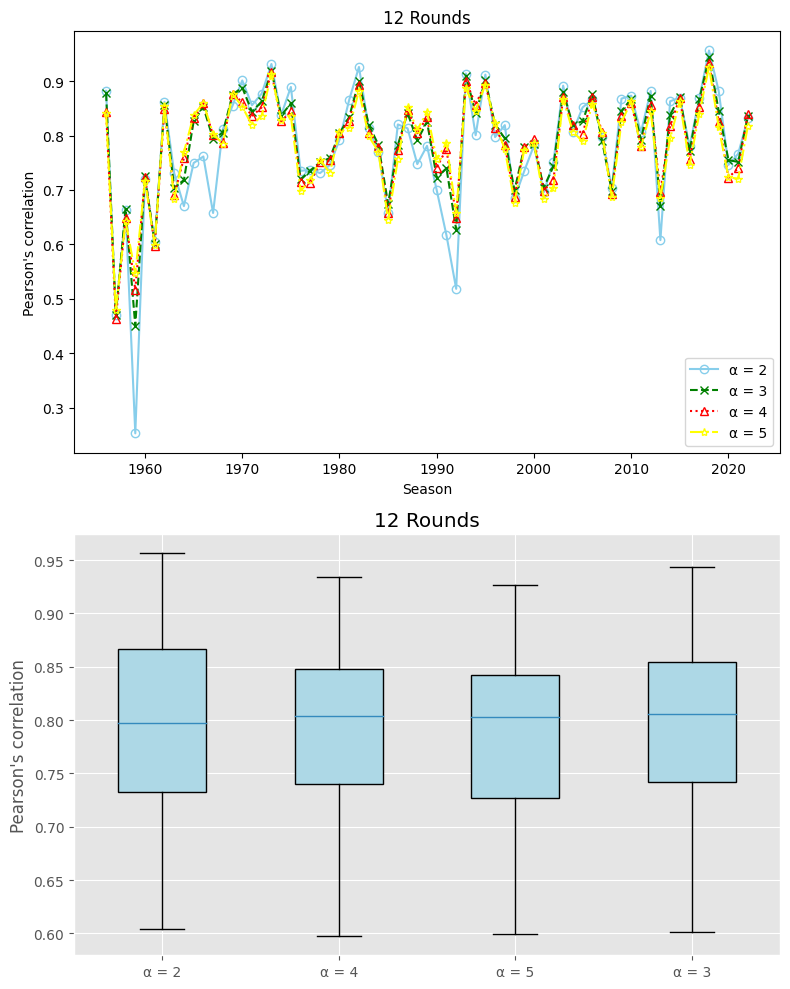

In [36]:
seasons = []
correlation_coefficients_benchmark_p = []
correlation_coefficients_new_p = []
correlation_coefficients_new_2_p = []
correlation_coefficients_direct_ranking_method_p = []
start_year = 1956
end_year = 2022  

for year in range(start_year, end_year + 1):
    season_data = dataframes_dict[year]
    correlation_benchmark = pearson_correlation_coefficient(alpha_markov(season_data, 12, 2, homeAdvantage), season_data)[0]
    correlation_new = pearson_correlation_coefficient(alpha_markov(season_data, 12, 3, homeAdvantage), season_data)[0]
    correlation_new_2 = pearson_correlation_coefficient(alpha_markov(season_data, 12, 4, homeAdvantage), season_data)[0]
    correlation_direct_ranking_method = pearson_correlation_coefficient(alpha_markov(season_data, 12, 5, homeAdvantage), season_data)[0]
    
    seasons.append(year)
    correlation_coefficients_benchmark_p.append(correlation_benchmark)
    correlation_coefficients_new_p.append(correlation_new)
    correlation_coefficients_new_2_p.append(correlation_new_2)
    correlation_coefficients_direct_ranking_method_p.append(correlation_direct_ranking_method)

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)

plt.plot(seasons, correlation_coefficients_benchmark_p, linestyle='-', marker = "o", color = "skyblue", fillstyle = "none",label= 'α = 2')
plt.plot(seasons, correlation_coefficients_new_p, linestyle='--', marker = "x", color = "green", fillstyle = "none", label='α = 3')
plt.plot(seasons, correlation_coefficients_new_2_p, linestyle=':', marker = "^", color = "red", fillstyle = "none", label= 'α = 4')
plt.plot(seasons, correlation_coefficients_direct_ranking_method_p, linestyle = "-.", marker = "*", color = "yellow", fillstyle = "none", label = 'α = 5')




plt.legend()
plt.title('12 Rounds')
plt.xlabel('Season')
plt.ylabel("Pearson's correlation")
plt.style.use('ggplot')

plt.subplot(2, 1, 2)

boxplot_labels = ['α = 2', 'α = 4',
                  "α = 5",  'α = 3']
boxplot_data = [correlation_coefficients_benchmark_p, correlation_coefficients_new_2_p,
                correlation_coefficients_direct_ranking_method_p, correlation_coefficients_new_p]

plt.boxplot(boxplot_data, labels=boxplot_labels, widths=0.5, showfliers=False, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))

plt.title('12 Rounds')
plt.ylabel("Pearson's correlation")

plt.tight_layout()

plt.show()

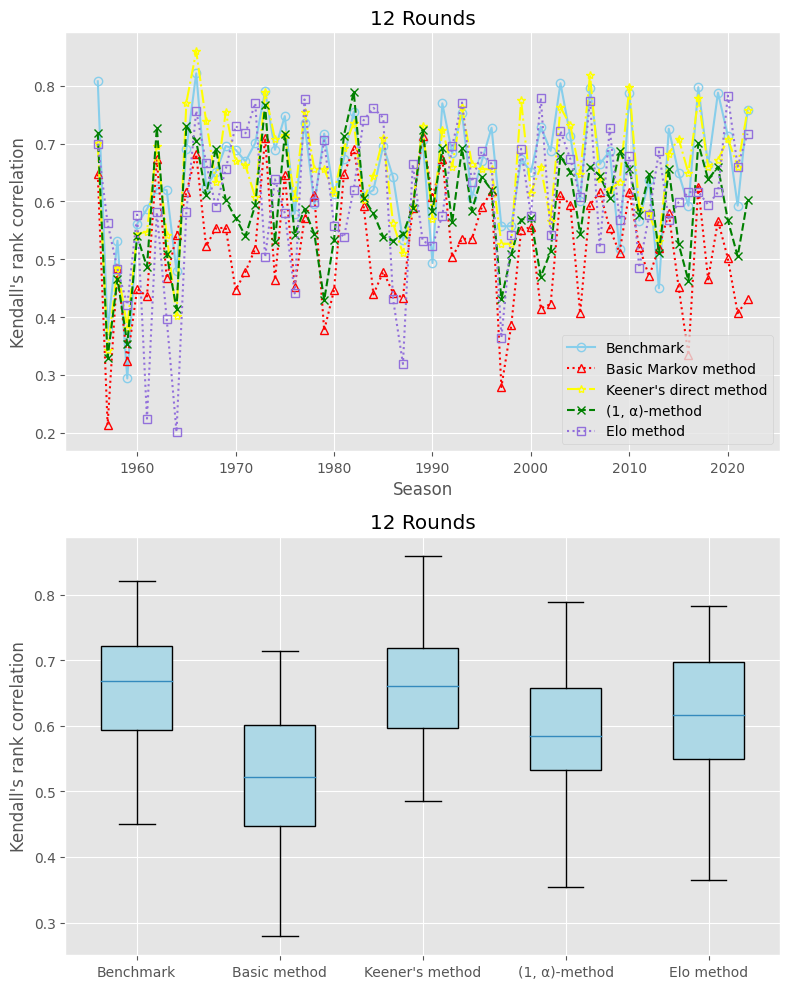

In [37]:
seasons = []
correlation_coefficients_benchmark = []
correlation_coefficients_new = []
correlation_coefficients_new_2 = []
correlation_coefficients_new_3 = []
correlation_coefficients_direct_ranking_method = []
start_year = 1956
end_year = 2022  

for year in range(start_year, end_year + 1):
    season_data = dataframes_dict[year]
    correlation_benchmark = kendall_correlation_coefficient(currently_used_ranking(season_data, 12), season_data)[0]
    correlation_new = kendall_correlation_coefficient(alpha_markov(season_data, 12, 5, homeAdvantage), season_data)[0]
    correlation_new_2 = kendall_correlation_coefficient(Elo_simulation(season_data, 12, year - 2), season_data)[0]
    correlation_new_3 = kendall_correlation_coefficient(Simple_Markov_Simulation(season_data, 12), season_data)[0]
    correlation_direct_ranking_method = kendall_correlation_coefficient(direct_ranking_method(season_data, 12), season_data)[0]
    
    seasons.append(year)
    correlation_coefficients_benchmark.append(correlation_benchmark)
    correlation_coefficients_new.append(correlation_new)
    correlation_coefficients_new_2.append(correlation_new_2)
    correlation_coefficients_new_3.append(correlation_new_3)
    correlation_coefficients_direct_ranking_method.append(correlation_direct_ranking_method)

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)

plt.plot(seasons, correlation_coefficients_benchmark, linestyle='-', marker = "o", color = "skyblue", fillstyle = "none",label='Benchmark')
plt.plot(seasons, correlation_coefficients_new_3, linestyle=':', marker = "^", color = "red", fillstyle = "none", label='Basic Markov method')
plt.plot(seasons, correlation_coefficients_direct_ranking_method, linestyle = "-.", marker = "*", color = "yellow", fillstyle = "none", label = "Keener's direct method")
plt.plot(seasons, correlation_coefficients_new, linestyle='--', marker = "x", color = "green", fillstyle = "none", label='(1, α)-method')
plt.plot(seasons, correlation_coefficients_new_2, linestyle=':', marker = "s", color = '#9370DB' , fillstyle = "none", label='Elo method')



plt.legend()
plt.title('12 Rounds')
plt.xlabel('Season')
plt.ylabel("Kendall's rank correlation" )
plt.style.use('ggplot')

plt.subplot(2, 1, 2)

boxplot_labels = ['Benchmark',"Basic method",
                  "Keener's method",  '(1, α)-method', 'Elo method']
boxplot_data = [correlation_coefficients_benchmark, correlation_coefficients_new_3,
                correlation_coefficients_direct_ranking_method, correlation_coefficients_new, correlation_coefficients_new_2]

plt.boxplot(boxplot_data, labels=boxplot_labels, widths=0.5, showfliers=False, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))

plt.title('12 Rounds')
plt.ylabel("Kendall's rank correlation")

plt.tight_layout()

plt.show()

Text(0, 0.5, "Kendall's rank correlation")

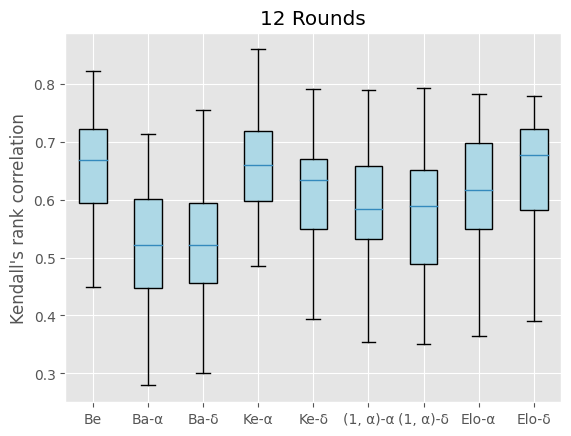

In [38]:
seasons = []
correlation_coefficients_benchmark_b = []
correlation_coefficients_new_b = []
correlation_coefficients_new_2_b = []
correlation_coefficients_new_3_b = []
correlation_coefficients_direct_ranking_method_b = []
start_year = 1956
end_year = 2022  

for year in range(start_year, end_year + 1):
    season_data = dataframes_dict[year]
    correlation_benchmark = kendall_correlation_coefficient(currently_used_ranking(season_data, 12), season_data)[0]
    correlation_new = kendall_correlation_coefficient(alpha_markov_d(season_data, 12, 5, homeAdvantage), season_data)[0]
    correlation_new_2 = kendall_correlation_coefficient(Elo_simulation_d(season_data, 12, year - 2), season_data)[0]
    correlation_new_3 = kendall_correlation_coefficient(Simple_Markov_Simulation_d(season_data, 12), season_data)[0]
    correlation_direct_ranking_method = kendall_correlation_coefficient(direct_ranking_method_d(season_data, 12), season_data)[0]
    
    seasons.append(year)
    correlation_coefficients_benchmark_b.append(correlation_benchmark)
    correlation_coefficients_new_b.append(correlation_new)
    correlation_coefficients_new_2_b.append(correlation_new_2)
    correlation_coefficients_new_3_b.append(correlation_new_3)
    correlation_coefficients_direct_ranking_method_b.append(correlation_direct_ranking_method)
    
boxplot_labels = ['Be', "Ba-α", "Ba-δ", "Ke-α", "Ke-δ", "(1, α)-α", "(1, α)-δ", "Elo-α", "Elo-δ"]
boxplot_data = [correlation_coefficients_benchmark, correlation_coefficients_new_3, correlation_coefficients_new_3_b,
                correlation_coefficients_direct_ranking_method, correlation_coefficients_direct_ranking_method_b, correlation_coefficients_new,  correlation_coefficients_new_b, 
                correlation_coefficients_new_2, correlation_coefficients_new_2_b]

plt.boxplot(boxplot_data, labels=boxplot_labels, widths=0.5, showfliers=False, patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))

plt.title('12 Rounds')
plt.ylabel("Kendall's rank correlation")

### Prediction of first place after 12 matchdays

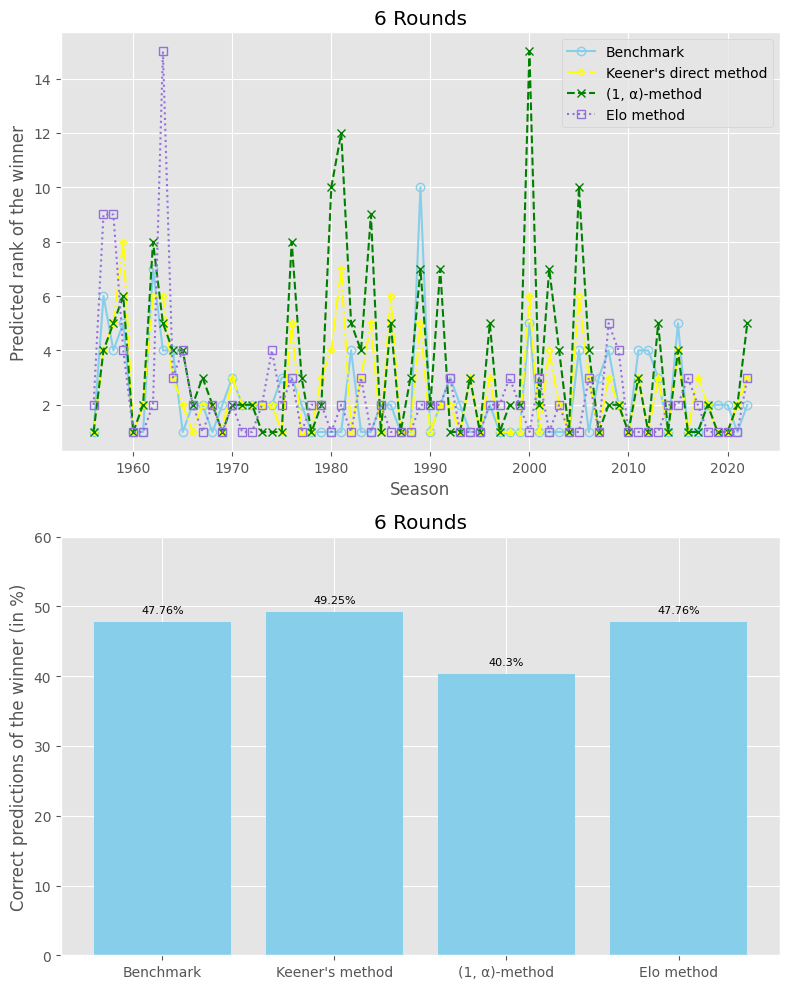

In [39]:
ranking_methods = ["0,1,3 point system", "(1, α) Markov", "Elo system"]
correct_predictions = [0,0,0]
start_year = 1956
end_year = 2022
seasons = []
number_of_seasons = 0

predicted_rank_first_place_benchmark = []
predicted_rank_first_place_alpha_markov = []
predicted_rank_first_place_elo = []
predicted_rank_first_place_direct_ranking_method = []
predicted_rank_first_place_basic = []

correct_predictions = [0, 0, 0, 0]

for year in range(start_year, end_year + 1):
    seasons.append(year)
    season_data = dataframes_dict[year]
    number_of_seasons += 1
   
    predicted_rank_first_place_benchmark.append(standings(season_data, 6)["Team"].tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)
    predicted_rank_first_place_alpha_markov.append(alpha_markov(season_data, 6, 2, homeAdvantage).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)        
    predicted_rank_first_place_elo.append(Elo_simulation(season_data, 6, year - 2).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)  
    predicted_rank_first_place_direct_ranking_method.append(direct_ranking_method(season_data, 6).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)  
#     predicted_rank_first_place_basic.append(Simple_Markov_Simulation(season_data,6).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)
    
    if standings(season_data, 12)["Team"][1] == standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]:
            correct_predictions[0] += 1
    
#     if Simple_Markov_Simulation(season_data, 12).index[0] == standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]:
#         correct_predictions[1] += 1
    
    if direct_ranking_method(season_data, 12).index[0] == standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]:
            correct_predictions[1] += 1
            
    if alpha_markov(season_data, 12, 2, homeAdvantage).index[0] == standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]:
            correct_predictions[2] += 1
        
    if Elo_simulation(season_data, 12, year - 2).index[0] == standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]:
            correct_predictions[3] += 1
             
percentages = [round((x / number_of_seasons) * 100, 2) for x in correct_predictions]

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)

plt.plot(seasons, predicted_rank_first_place_benchmark, linestyle='-', marker = "o", color = "skyblue", fillstyle = "none",label='Benchmark')
# plt.plot(seasons, predicted_rank_first_place_basic, linestyle=':', marker = "^", color = "red", fillstyle = "none", label='Basic Markov method')
plt.plot(seasons, predicted_rank_first_place_direct_ranking_method, linestyle = "-.", marker = "*", color = "yellow", fillstyle = "none", label = "Keener's direct method")
plt.plot(seasons, predicted_rank_first_place_alpha_markov, linestyle='--', marker = "x", color = "green", fillstyle = "none", label='(1, α)-method')
plt.plot(seasons, predicted_rank_first_place_elo, linestyle=':', marker = "s", color = '#9370DB' , fillstyle = "none", label='Elo method')


plt.legend()
plt.title('6 Rounds')
plt.xlabel('Season')
plt.ylabel('Predicted rank of the winner')
plt.style.use('ggplot')
        
plt.subplot(2, 1, 2)
barchart_labels = ['Benchmark',#"Basic method",
                   "Keener's method",  '(1, α)-method', 'Elo method']

plt.bar(barchart_labels, percentages, color='skyblue')

plt.title('6 Rounds')
plt.ylabel('Correct predictions of the winner (in %)')
plt.ylim((0,60))
for i, pct in enumerate(percentages):
    plt.text(i, pct + 1, f'{pct}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

plt.show()

# print(f"Average Benchmark: {round(np.mean(predicted_rank_first_place_benchmark), 2)}, "
#       f"Average Alpha Markov: {round(np.mean(predicted_rank_first_place_alpha_markov), 2)}, "
#       f"Average Elo: {round(np.mean(predicted_rank_first_place_elo), 2)}, "
#       f"Average Direct Ranking Method: {round(np.mean(predicted_rank_first_place_direct_ranking_method), 2)}")


Best Alpha: 3
Best Mean Correlation: 2.283582089552239


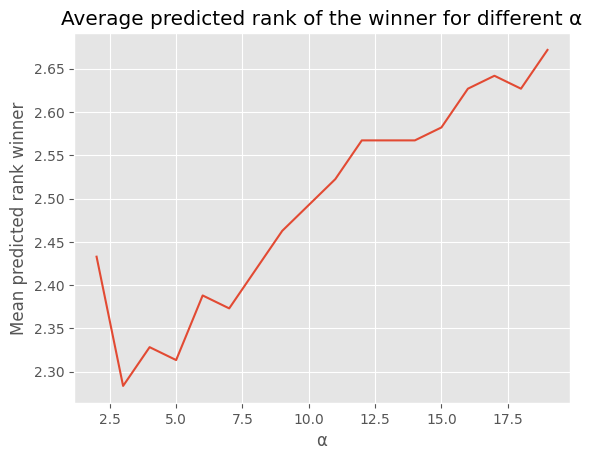

In [40]:
alpha_values = np.arange(2, 20)  # Adjust the range as needed

best_alpha = None
best_mean_correlation = 1000  # Initialize with a negative value to ensure any value is an improvement

correlation_coefficients_for_alphas = []

for alpha in alpha_values:
    mean_correlation = 0  # Initialize mean correlation for the current alpha
    for year in range(start_year, end_year + 1):
        season_data = dataframes_dict[year]
        correlation_new = (alpha_markov(season_data, 12, alpha, homeAdvantage).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)
        mean_correlation += correlation_new
    mean_correlation /= len(range(start_year, end_year + 1))  # Calculate the mean correlation
    correlation_coefficients_for_alphas.append(mean_correlation)  # Store mean correlation for the current alpha
    
    if mean_correlation < best_mean_correlation:
        best_mean_correlation = mean_correlation
        best_alpha = alpha

plt.plot(alpha_values, correlation_coefficients_for_alphas)
plt.ylabel('Mean predicted rank winner')
plt.xlabel('α')
plt.title('Average predicted rank of the winner for different α') 
# Print the best alpha and its corresponding mean correlation
print(f"Best Alpha: {best_alpha}")
print(f"Best Mean Correlation: {best_mean_correlation}")


In [41]:
print(correlation_coefficients_for_alphas)

[2.4328358208955225, 2.283582089552239, 2.328358208955224, 2.3134328358208953, 2.388059701492537, 2.373134328358209, 2.417910447761194, 2.462686567164179, 2.4925373134328357, 2.5223880597014925, 2.5671641791044775, 2.5671641791044775, 2.5671641791044775, 2.582089552238806, 2.626865671641791, 2.6417910447761193, 2.626865671641791, 2.671641791044776]


Best Alpha: 1
Best Mean Correlation: 2.044776119402985


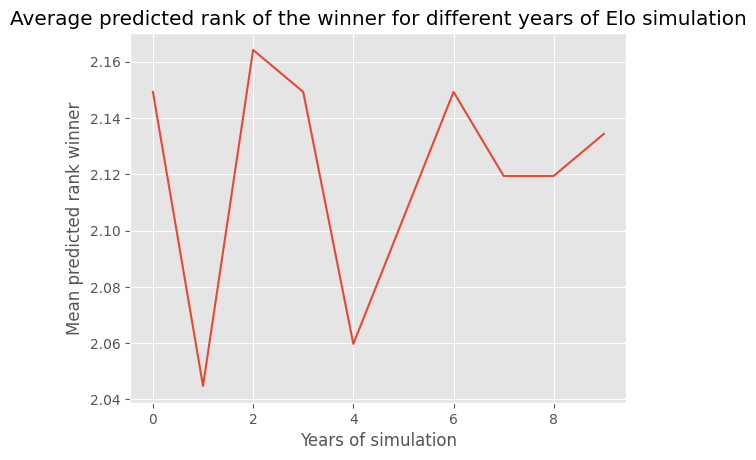

In [42]:
alpha_values = np.arange(0, 10)  # Adjust the range as needed

best_alpha = None
best_mean_correlation = 1000  # Initialize with a negative value to ensure any value is an improvement

correlation_coefficients_for_alphas = []

for alpha in alpha_values:
    mean_correlation = 0  # Initialize mean correlation for the current alpha
    for year in range(start_year, end_year + 1):
        season_data = dataframes_dict[year]
        correlation_new = (Elo_simulation(season_data, 12, year - alpha).index.tolist().index(standings(season_data, season_data["Matchday"].iloc[-1])["Team"][1]) + 1)
        mean_correlation += correlation_new
    mean_correlation /= len(range(start_year, end_year + 1))  # Calculate the mean correlation
    correlation_coefficients_for_alphas.append(mean_correlation)  # Store mean correlation for the current alpha
    
    if mean_correlation < best_mean_correlation:
        best_mean_correlation = mean_correlation
        best_alpha = alpha

plt.plot(alpha_values, correlation_coefficients_for_alphas)
plt.ylabel('Mean predicted rank winner')
plt.xlabel('Years of simulation')
plt.title('Average predicted rank of the winner for different years of Elo simulation') 
# Print the best alpha and its corresponding mean correlation
print(f"Best Alpha: {best_alpha}")
print(f"Best Mean Correlation: {best_mean_correlation}")


## Test for significant differences between the methods

In [43]:
print(stats.ttest_ind(correlation_coefficients_new_p, correlation_coefficients_benchmark_p))
print(stats.ttest_ind(correlation_coefficients_new_p, correlation_coefficients_direct_ranking_method_p))
print(stats.ttest_ind(correlation_coefficients_new_p, correlation_coefficients_new_2_p))
print(stats.ttest_ind(correlation_coefficients_benchmark_p, correlation_coefficients_direct_ranking_method_p))
print(stats.ttest_ind(correlation_coefficients_new_2_p, correlation_coefficients_direct_ranking_method_p))
print(stats.ttest_ind(correlation_coefficients_new_2_p, correlation_coefficients_benchmark_p))

Ttest_indResult(statistic=0.6272254262957799, pvalue=0.5315949078159787)
Ttest_indResult(statistic=0.546709612989648, pvalue=0.5855012388885353)
Ttest_indResult(statistic=0.24655882200455173, pvalue=0.8056326963568864)
Ttest_indResult(statistic=-0.1707863461379167, pvalue=0.8646532753481335)
Ttest_indResult(statistic=0.3054649168639105, pvalue=0.7604932608023266)
Ttest_indResult(statistic=0.42473689517610674, pvalue=0.6717199986124955)


In [44]:
print(stats.ttest_ind(correlation_coefficients_new, correlation_coefficients_benchmark))
print(stats.ttest_ind(correlation_coefficients_new, correlation_coefficients_direct_ranking_method))
print(stats.ttest_ind(correlation_coefficients_new, correlation_coefficients_new_2))
print(stats.ttest_ind(correlation_coefficients_benchmark, correlation_coefficients_direct_ranking_method))
print(stats.ttest_ind(correlation_coefficients_new_2, correlation_coefficients_direct_ranking_method))
print(stats.ttest_ind(correlation_coefficients_new_2, correlation_coefficients_benchmark))
print(stats.ttest_ind(correlation_coefficients_new_3, correlation_coefficients_benchmark))
print(stats.ttest_ind(correlation_coefficients_new_3, correlation_coefficients_direct_ranking_method))
print(stats.ttest_ind(correlation_coefficients_new_3, correlation_coefficients_new))
print(stats.ttest_ind(correlation_coefficients_new_3, correlation_coefficients_new_2))
print(stats.ttest_ind(correlation_coefficients_new, correlation_coefficients_new_2_b))

Ttest_indResult(statistic=-3.730787105372211, pvalue=0.00028247737306251165)
Ttest_indResult(statistic=-3.6112202772144193, pvalue=0.00043173374741144985)
Ttest_indResult(statistic=-0.8594187591332061, pvalue=0.3916676041563413)
Ttest_indResult(statistic=0.14818852675208324, pvalue=0.8824201194125277)
Ttest_indResult(statistic=-2.256564139472648, pvalue=0.025679215347169895)
Ttest_indResult(statistic=-2.372271735016479, pvalue=0.019122809242468026)
Ttest_indResult(statistic=-7.3408925612543525, pvalue=1.9466128769545497e-11)
Ttest_indResult(statistic=-7.254778787284106, pvalue=3.0705984868307275e-11)
Ttest_indResult(statistic=-3.879511082069108, pvalue=0.0001644331496736757)
Ttest_indResult(statistic=-4.178426720317077, pvalue=5.304840292645106e-05)
Ttest_indResult(statistic=-2.464109870430786, pvalue=0.015021284373494924)


### Implementation of variables that are dependent on the outcome of the match

Thuis en uitvoordeel berekenen. GEDAAN
Plaatjes herstellen. GEDAAN 
Nieuwe methode implementeren (TU Eindhoven).-GEDAAN
Statistische tests uitvoeren. - GEDAAN

Na 6 speelrondes en 12 speelrondes, (eventueel 18 speelrondes).
Intermezzo: Wat zou er gebeuren in het coronaseizoen.





Idea: Strength in the first couple of rounds of play can be determined based on the final standings of last season. 
After a couple of rounds, strength could gradually become more dependent on the current standings. Meaning that winning against someone at the top of the table would gain more strength than winning from someone at the bottom of the table. 